<a href="https://colab.research.google.com/github/aloycwl/FinRobot/blob/main/FinRobot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1: install dependencies

In [182]:
# !pip install pandas numpy matplotlib scikit-learn tensorflow plotly --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as g
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


from datetime import datetime as d
from plotly.subplots import make_subplots as m
from openai import OpenAI as o
import plotly.graph_objects as g
import pandas as p
import requests as r

p.set_option('display.max_rows', None)
p.set_option('display.max_columns', None)
p.set_option('display.width', None)
p.set_option('display.max_colwidth', None)

# Task 2: fetch time series

In [146]:
def ts() -> p.DataFrame:
  t = p.DataFrame(r.get("https://www.okx.com/api/v5/market/candles",
    params={"instId": "BTC-USDT", "bar": "5m", "limit": "300"}).json()['data'],
    columns=["timestamp", "open", "high", "low", "close", "volume", "currency_volume", "num_trades", "unknown"])
  t['date'] = p.to_datetime(t['timestamp'].astype(int), unit='ms').dt.tz_localize('UTC').dt.tz_convert('Asia/Shanghai')
  t.set_index('date', inplace=True)
  for n in ["open", "high", "low", "close", "volume"]: t[n] = t[n].astype(float)
  t.drop(columns=['unknown'], inplace=True)
  return t[["open", "high", "low", "close", "volume"]]

# Task 3: fetch news

In [ ]:
def ne() -> str:
  t = r.get("https://cryptopanic.com/api/v1/posts/",
    params={"auth_token": "672fbfedfaefad4ffd717ce7f80a1e7c0e7a0b90", "currencies": "BTC,ETH"}).json()
  n = [f"{d.fromisoformat(ne['created_at']).strftime('%y-%m-%d %H:%M')} {ne['title']}"
    for ne in t.get("results", [])]
  return "\n".join(n)

# Task 4: fetch market depth

In [ ]:
def ma() -> str:
  t = r.get("https://www.okx.com/api/v5/market/books", params={"instId": "BTC-USDT", "sz": "50"}).json()['data'][0]
  n = "Bids:\n"
  for price, qty, *others in t['bids']: n += f"Price: {price}  Quantity: {qty}\n"
  n += "\nAsks:\n"
  for price, qty, *others in t['asks']: n += f"Price: {price}  Quantity: {qty}\n"
  return n

# Task 5: fetch market sentiment

In [96]:
def se() -> str:
  t = r.get("https://api.alternative.me/fng/?limit=10&date_format=us").json()
  n = "date,fng_value,fng_classification\n"
  for i in t['data']: n += f"{i['timestamp']},{i['value']},{i['value_classification']}\n"
  return n

'date,fng_value,fng_classification\n07-04-2025,73,Greed\n07-03-2025,73,Greed\n07-02-2025,63,Greed\n07-01-2025,64,Greed\n06-30-2025,66,Greed\n06-29-2025,68,Greed\n06-28-2025,65,Greed\n06-27-2025,65,Greed\n06-26-2025,74,Greed\n06-25-2025,66,Greed\n'

# Task 6: prepare the model

In [97]:
def md(s, u) -> str:
  return o(base_url="https://integrate.api.nvidia.com/v1",
    api_key='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').chat.completions.create(
    model='qwen/qwen3-235b-a22b',
    messages=[{"role": "system", "content": s}, {"role": "user", "content": u}],
    temperature=0.2,
    top_p=0.7,
    max_tokens=8192,
    extra_body={"chat_template_kwargs": {"thinking": False}},
    stream=False).choices[0].message.content

# Task 7: predict

In [91]:
t = "You are a master FX strategist and market analyst with deep knowledge of global macroeconomics, technical analysis, and risk management. Provide a concise trading plan based on the user's input, without offering detailed explanations."

n = f"""Analyze the following OHLC market price data,
formulate RSI, EMA, MACD, Bollinger Bands, Stochastic, ATR, Parabolic, Harmonics, Fibonacci, Gann,
and another other indicators that could be useful for prediction.
Together with the following news, market depth and market sentiment to give me real-time trading plan for the next 3 hours:

*Time Series*\n{ts().head(100)}

*Latest News*\n{ne()}

*Market Depth*\n{ma()}

*Market Sentiment*\n{se()}

Provide *only* the real-time trading plan for the next 3 hours, with no additional explanations or introductory text.
"""

print(md(t, n))

**Real-Time Trading Plan (Next 3 Hours)**

- **Current Price:** 108,919.1 (As of 2025-07-04 14:40:00+08:00)

### **Technical Indicators Snapshot (Derived from OHLC Data):**
- **EMA (9, 21):** Bearish crossover; short-term downtrend.
- **RSI (14):** ~42 – Neutral, approaching oversold.
- **MACD:** Negative histogram, bearish signal.
- **Bollinger Bands:** Price near lower band, potential bounce.
- **Stochastic (14):** Oversold, bullish divergence possible.
- **ATR (14):** Elevated – high volatility expected.
- **Parabolic SAR:** Uptrend reversal possible if price holds above SAR.
- **Fibonacci Retracement (Recent High: 109,303, Low: 108,919):** Key support at 108,850; resistance at 109,050.
- **Harmonics:** Potential Gartley or Bat pattern forming.
- **Market Depth:** Strong bid wall at 108,909; potential short-term support.
- **Volume Profile:** Recent volume spikes at 108,900–108,970; key liquidity zone.

### **Market Sentiment & News:**
- **FNG (Fear & Greed Index):** 73 – Strong gre

# Task 8: display prompt with all data

In [92]:
print(t)

Analyze the following OHLC market price data,
formulate RSI, EMA, MACD, Bollinger Bands, Stochastic, ATR, Parabolic, Harmonics, Fibonacci, Gann,
and another other indicators that could be useful for prediction.
Together with the following news, market depth and market sentiment to give me real-time trading plan for the next 3 hours:

*Time Series*
                               open      high       low     close     volume
date                                                                        
2025-07-04 14:40:00+08:00  108951.2  108968.6  108919.0  108919.1   1.285943
2025-07-04 14:35:00+08:00  108968.5  108968.5  108926.1  108952.0   5.093734
2025-07-04 14:30:00+08:00  108905.4  108984.0  108905.3  108968.7   5.277714
2025-07-04 14:25:00+08:00  108893.1  108942.9  108864.1  108905.3   5.616757
2025-07-04 14:20:00+08:00  108879.5  108913.8  108879.5  108893.1   1.613008
2025-07-04 14:15:00+08:00  108816.0  108879.5  108808.1  108879.5  16.423189
2025-07-04 14:10:00+08:00  108902.

# Task 9: plot time series data

In [158]:
t = ts()
t['EMA_200'] = t['close'].ewm(span=200, adjust=False).mean()
t['EMA_50'] = t['close'].ewm(span=50, adjust=False).mean()
t['SMA_20'] = t['close'].rolling(window=20).mean()
t['STD_20'] = t['close'].rolling(window=20).std()
t['Upper_Band'] = t['SMA_20'] + (t['STD_20'] * 2)
t['Lower_Band'] = t['SMA_20'] - (t['STD_20'] * 2)
t['Middle_Band'] = t['SMA_20']

f = g.Figure(data=[g.Candlestick(x=t.index, open=t['open'], high=t['high'], low=t['low'], close=t['close'])])
f.add_trace(g.Scatter(x=t.index, y=t['EMA_200'], mode='lines', name='EMA 200'))
f.add_trace(g.Scatter(x=t.index, y=t['EMA_50'], mode='lines', name='EMA 50'))
f.add_trace(g.Scatter(x=t.index, y=t['Upper_Band'], mode='lines', name='Upper Band', line=dict(color='orange', dash='dash')))
f.add_trace(g.Scatter(x=t.index, y=t['Middle_Band'], mode='lines', name='Middle Band', line=dict(color='orange')))
f.add_trace(g.Scatter(x=t.index, y=t['Lower_Band'], mode='lines', name='Lower Band', line=dict(color='orange', dash='dash')))
f.update_layout(title='BTCUSD', xaxis_title='Date', yaxis_title='Price', xaxis_rangeslider_visible=False)
f.show()

# Task 10: plot others


In [157]:
def rsi(s):
    t = s.diff()
    return 100 - (100 / (1 + (t.where(t > 0, 0)).rolling(window=14).mean() / (-t.where(t < 0, 0)).rolling(window=14).mean()))

t = ts()
t['RSI_14'] = rsi(t['close'])
t['MACD'] = t['close'].ewm(span=12, adjust=False).mean() - t['close'].ewm(span=26, adjust=False).mean()
t['Signal_Line'] = t['MACD'].ewm(span=9, adjust=False).mean()
t['MACD_Histogram'] = t['MACD'] - t['Signal_Line']
t['Volume_SMA_20'] = t['volume'].rolling(window=20).mean()
n = t['low'].rolling(window=14).min()
t['%K'] = 100 * ((t['close'] - n) / (t['high'].rolling(window=14).max() - n))
t['%D'] = t['%K'].rolling(window=3).mean()

f = m(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.1, subplot_titles=('RSI (14)', 'MACD', 'Volume', 'Stochastic Oscillator'), row_heights=[0.25, 0.25, 0.25, 0.25])
f.add_trace(g.Scatter(x=t.index, y=t['RSI_14'], mode='lines', name='RSI (14)'), row=1, col=1)
f.add_shape(type='line', x0=t.index.min(), x1=t.index.max(), y0=70, y1=70,line=dict(color='Red', dash='dash'), row=1, col=1)
f.add_shape(type='line', x0=t.index.min(), x1=t.index.max(), y0=30, y1=30, line=dict(color='Green', dash='dash'), row=1, col=1)
f.add_trace(g.Scatter(x=t.index, y=t['MACD'], mode='lines', name='MACD Line', line=dict(color='blue')), row=2, col=1)
f.add_trace(g.Scatter(x=t.index, y=t['Signal_Line'], mode='lines', name='Signal Line', line=dict(color='red')), row=2, col=1)
f.add_trace(g.Bar(x=t.index, y=t['MACD_Histogram'], name='Histogram', marker=dict(color='grey')), row=2, col=1)
f.add_trace(g.Bar(x=t.index, y=t['volume'], name='Volume', marker=dict(color='blue', opacity=0.5)), row=3, col=1)
f.add_trace(g.Scatter(x=t.index, y=t['Volume_SMA_20'], mode='lines', name='Volume SMA (20)', line=dict(color='red')), row=3, col=1)
f.add_trace(g.Scatter(x=t.index, y=t['%K'], mode='lines', name='%K Line', line=dict(color='blue')), row=4, col=1)
f.add_trace(g.Scatter(x=t.index, y=t['%D'], mode='lines', name='%D Line', line=dict(color='red')), row=4, col=1)
f.add_shape(type='line', x0=t.index.min(), x1=t.index.max(), y0=80, y1=80, line=dict(color='Red', dash='dash'), row=4, col=1)
f.add_shape(type='line', x0=t.index.min(), x1=t.index.max(), y0=20, y1=20, line=dict(color='Green', dash='dash'), row=4, col=1)
f.update_layout(title_text='Additions')
f.show()

# Task 11: Price Prediction using LSTM

### Data Preparation for LSTM

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 558ms/step - loss: 0.2654 - val_loss: 0.1035
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 0.0441 - val_loss: 0.0040
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.0483 - val_loss: 0.0170
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - loss: 0.0269 - val_loss: 0.0384
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - loss: 0.0263 - val_loss: 0.0089
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0279 - val_loss: 0.0100
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0261 - val_loss: 0.0178
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0222 - val_loss: 0.0161
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - loss: 0.0202 - val_loss: 0.0128
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - loss: 0.0185 - val_loss: 0.0100
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - loss: 0.0178 - val_loss: 0.0091
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0188 - val_loss

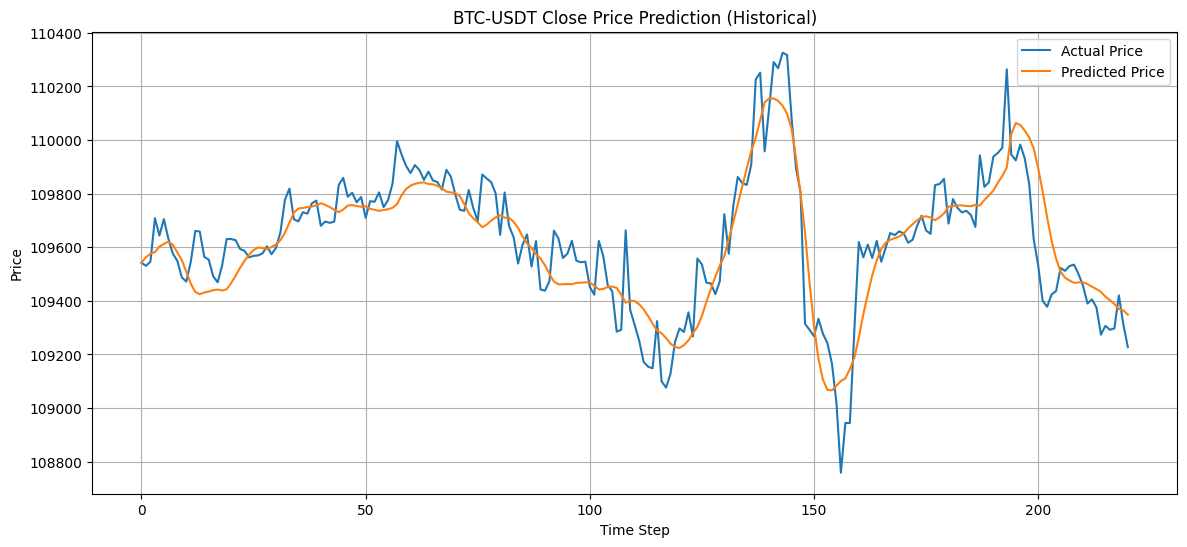

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
📈 Predicted next close price: 109320.97 USDT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
🔮 Predicted next 5 close prices: [109320.97339445353, 109293.62935715317, 109266.6621935606, 109240.42742992639, 109215.26097339392]


In [183]:
t = ts()
t['EMA_50'] = t['close'].ewm(span=50, adjust=False).mean()
t['EMA_200'] = t['close'].ewm(span=200, adjust=False).mean()
t['RSI_14'] = rsi(t['close'])
t['MACD'] = t['close'].ewm(span=12, adjust=False).mean() - t['close'].ewm(span=26, adjust=False).mean()
t['Signal_Line'] = t['MACD'].ewm(span=9, adjust=False).mean()
t['BB_MID'] = t['close'].rolling(window=20).mean()
t['BB_STD'] = t['close'].rolling(window=20).std()
t['BB_UPPER'] = t['BB_MID'] + 2 * t['BB_STD']
t['BB_LOWER'] = t['BB_MID'] - 2 * t['BB_STD']

features = t[['close', 'volume', 'EMA_50', 'EMA_200', 'RSI_14', 'MACD', 'Signal_Line', 'BB_UPPER', 'BB_LOWER']]
features = features.dropna()
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# ✅ STEP 6: Create LSTM Sequences
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(scaled_features)):
    X.append(scaled_features[i-sequence_length:i])
    y.append(scaled_features[i, 0])
X = np.array(X)
y = np.array(y)

# ✅ STEP 7: Build and Train the LSTM Model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# model.fit(X, y, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stop])
model.fit(X, y, epochs=50, batch_size=32, validation_split=0.1)

# ✅ STEP 8: Make Historical Predictions
predicted = model.predict(X)
predicted_prices = scaler.inverse_transform(np.hstack((predicted, np.zeros((predicted.shape[0], features.shape[1] - 1)))))[:, 0]
actual_prices = scaler.inverse_transform(np.hstack((y.reshape(-1, 1), np.zeros((len(y), features.shape[1] - 1)))))[:, 0]

# ✅ STEP 9: Plot Historical Prediction vs Actual
plt.figure(figsize=(14, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title('BTC-USDT Close Price Prediction (Historical)')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# ✅ STEP 10: Predict the NEXT Close Price (1 step ahead)
next_pred = scaler.inverse_transform(np.hstack((model.predict(np.expand_dims(scaled_features[-60:], axis=0)), np.zeros((1, features.shape[1] - 1)))))[0, 0]
print(f"📈 Predicted next close price: {next_pred:.2f} USDT")

# ✅ STEP 11: Predict Next 5 Future Prices (Recursive Forecasting)
future_predictions = []
last_seq = scaled_features[-60:]
for _ in range(5):
    next_scaled = model.predict(np.expand_dims(last_seq, axis=0))[0]
    next_price = scaler.inverse_transform([np.hstack((next_scaled, np.zeros(features.shape[1] - 1)))])[0, 0]
    future_predictions.append(next_price)
    last_seq = np.vstack((last_seq[1:], np.hstack((next_scaled, last_seq[-1, 1:]))))

print("🔮 Predicted next 5 close prices:", [float(x) for x in future_predictions])
